# Imports

In [1]:
import pandas as pd
import numpy as np

# Read data

In [2]:
# Read data
df = pd.read_csv('/kaggle/input/ibm-classification-feature-engineering/all_data.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)

In [3]:
df.head(5)

,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Unemployment Rate (%),Consumer Confidence Index,...,MACD,MACD Signal Line,MACD Histogram,MACD-V,MACD-V Signal Line,MACD-V Histogram,Stochastic Oscillator %K,Stochastic Oscillator %D,Stochastic Oscillator Histogram,1-week Forward Return Sign
0,179,79.109352,117.541809,118.311035,117.508362,117.834450,2295244.0,1936.92,6.1,92.4,...,-0.638684,-0.430424,-0.208259,-1.606591,-1.081145,-0.525446,26.875023,21.958301,4.916721,1.0
1,26,46.221848,72.696129,72.878838,72.216515,72.581932,1603582.0,1936.92,6.1,92.4,...,-0.195987,-0.138043,-0.057944,-0.722557,-0.509002,-0.213555,47.656281,33.562224,14.094057,1.0
2,412,31.606541,36.820000,36.992001,36.007999,36.467999,1169750.0,1936.92,6.1,92.4,...,-0.254930,-0.362488,0.107558,-4.684555,-6.641059,1.956503,84.266255,73.116252,11.150004,1.0
3,135,70.018379,95.585785,96.812103,95.346275,95.997757,2579793.0,1936.92,6.1,92.4,...,-0.350198,-0.376494,0.026296,-1.325537,-1.423234,0.097696,60.081450,48.607778,11.473673,1.0
4,219,75.137581,103.604988,104.036430,102.876320,103.614571,1431100.0,1936.92,6.1,92.4,...,-0.916201,-0.959363,0.043162,-3.116435,-3.253232,0.136796,69.618419,48.947391,20.671028,1.0


# Feature Selection

Throughout this notebook, we use this article on feature selection to help out https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection

We split into training and test sets. We then drop the 'Date' column as it shouldn't be used as a feature.

In [4]:
# Drop nans
df.dropna(inplace=True, ignore_index=True)

In [5]:
# Training set
X_train = df[(df['Year'] >= 2014) & (df['Year'] <= 2020)]
y_train = X_train['1-week Forward Return Sign']
X_train.drop(['1-week Forward Return Sign'], inplace=True, axis=1)

# Test set
X_test = df[df['Year'] >= 2021]
y_test = X_test['1-week Forward Return Sign']
X_test.drop(['1-week Forward Return Sign'], inplace=True, axis=1)

# Print shapes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (753533, 277)
y_train: (753533,)
X_test: (153972, 277)
y_test: (153972,)


/tmp/ipykernel_18/4035320645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['1-week Forward Return Sign'], inplace=True, axis=1)
/tmp/ipykernel_18/4035320645.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['1-week Forward Return Sign'], inplace=True, axis=1)


In [6]:
# Scale features using training set mean and std to avoid look-ahead bias
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(
    data=scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_normalized = pd.DataFrame(
    data=scaler.transform(X_test),
    columns=X_test.columns
)

## Filter Methods

Filter methods are generally used as a preprocessing step. The selection of features is independent of any machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. For classification problems like this one, correlation-based filter methods tend to yield the best results and are less computationally expensive than training a model and doing some sort of recursive feature selection.

### Remove low variance features

In [7]:
# Check if any features have 0 variance
from sklearn.feature_selection import VarianceThreshold
zero_threshold = VarianceThreshold(threshold=0)
zero_threshold.fit(X_train)
num_constant_features = len(X_train.columns) - sum(zero_threshold.get_support())
print(f"There are {num_constant_features} constant features")

There are 0 constant features


In [8]:
# Find 'almost' constant features
almost_constant_threshold = VarianceThreshold(threshold=0.01)
almost_constant_threshold.fit(X_train_normalized)
num_almost_constant_features = len(X_train_normalized.columns) - sum(almost_constant_threshold.get_support())
print(f"There are {num_almost_constant_features} almost constant features")
print([c for c in X_train_normalized.columns if c not in X_train_normalized.columns[almost_constant_threshold.get_support()]])

# Remove 'almost constant' features
X_train_normalized = pd.DataFrame(almost_constant_threshold.transform(X_train_normalized), columns=X_train_normalized.columns[almost_constant_threshold.get_support()])
X_test_normalized = pd.DataFrame(almost_constant_threshold.transform(X_test_normalized), columns=X_test_normalized.columns[almost_constant_threshold.get_support()])

# Check shapes to ensure features have been removed
print(f"X_train_normalized: {X_train_normalized.shape}")
print(f"X_test_normalized: {X_test_normalized.shape}")

There are 0 almost constant features
[]
X_train_normalized: (753533, 277)
X_test_normalized: (153972, 277)


### Remove highly correlated features using correlation matrix

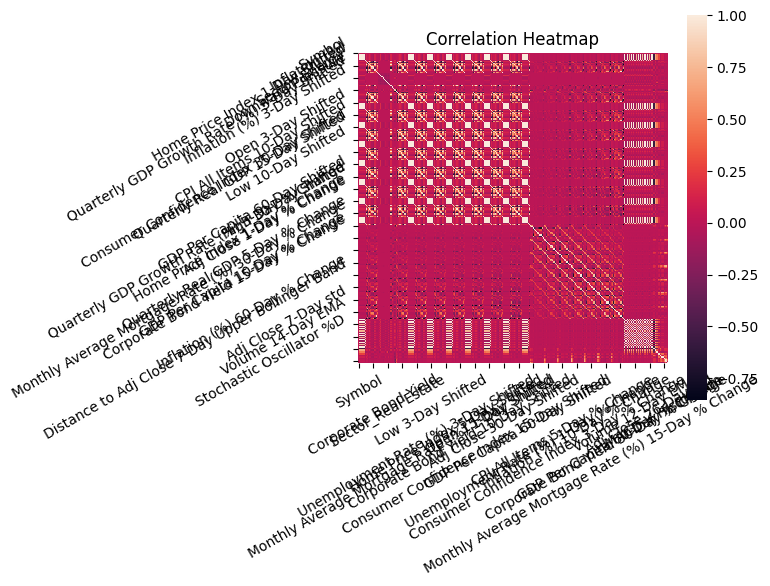

In [9]:
# Create correlation matrix of remaining features
corr_matrix = X_train_normalized.corr()

# Create correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

In [10]:
# Get columns of correlation matrix that have high correlation to other features (need upper triangular matrix to stop wrong features being dropped)
correlation_threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in list(upper.columns) if any(upper[column] > correlation_threshold)]
print(to_drop)  

['Close', 'High', 'Low', 'Open', 'CPI All Items', 'GDP Per Capita', 'Quarterly Real GDP', 'Year', 'Unemployment Rate (%) 1-Day Shifted', 'Consumer Confidence Index 1-Day Shifted', 'CPI All Items 1-Day Shifted', 'Inflation (%) 1-Day Shifted', 'Monthly Average Mortgage Rate (%) 1-Day Shifted', 'Corporate Bond Yield 1-Day Shifted', 'GDP Per Capita 1-Day Shifted', 'Quarterly Real GDP 1-Day Shifted', 'Quarterly GDP Growth Rate (%) 1-Day Shifted', 'Home Price Index 1-Day Shifted', 'Adj Close 1-Day Shifted', 'Close 1-Day Shifted', 'High 1-Day Shifted', 'Low 1-Day Shifted', 'Open 1-Day Shifted', 'Volume 1-Day Shifted', 'S&P500 1-Day Shifted', 'Unemployment Rate (%) 3-Day Shifted', 'Consumer Confidence Index 3-Day Shifted', 'CPI All Items 3-Day Shifted', 'Inflation (%) 3-Day Shifted', 'Monthly Average Mortgage Rate (%) 3-Day Shifted', 'Corporate Bond Yield 3-Day Shifted', 'GDP Per Capita 3-Day Shifted', 'Quarterly Real GDP 3-Day Shifted', 'Quarterly GDP Growth Rate (%) 3-Day Shifted', 'Home Pri

In [11]:
# Drop highly correlated features from X_train and X_test
X_train_normalized.drop(to_drop, axis=1, inplace=True)
X_test_normalized.drop(to_drop, axis=1, inplace=True)

# Check shapes to ensure features have been removed
print(f"X_train_normalized: {X_train_normalized.shape}")
print(f"X_test_normalized: {X_test_normalized.shape}")

X_train_normalized: (753533, 127)
X_test_normalized: (153972, 127)


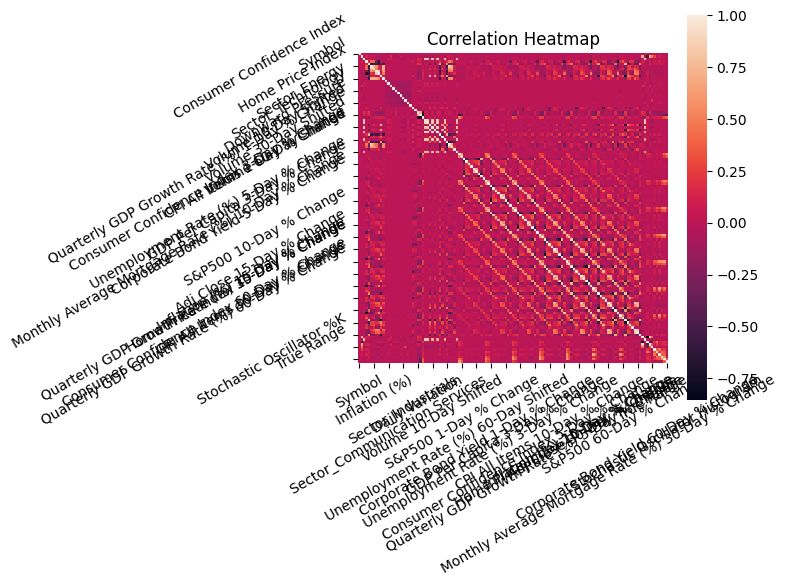

In [12]:
# Create correlation matrix of remaining features
corr_matrix = X_train_normalized.corr()

# Create correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

### ANOVA F-value

The F-value scores examine if, when we group a numerical feature by the target vector, the means for each group are significantly different. We can pick the 100 best remaining features based on these scored

In [13]:
# Select Features With Best ANOVA F-Values
from sklearn.feature_selection import SelectKBest, f_classif
fvalue_selector = SelectKBest(f_classif, k=120)
X_train_normalized_selected = fvalue_selector.fit_transform(X_train_normalized, y_train)

# Create dataframes with selected features only
selected_feature_indices = fvalue_selector.get_support(indices=True)
selected_feature_names = X_train_normalized.columns[selected_feature_indices]
X_train_normalized = pd.DataFrame(
    data=X_train_normalized_selected, 
    columns=selected_feature_names
)
X_test_normalized = pd.DataFrame(
    data=X_test_normalized[selected_feature_names], 
    columns=selected_feature_names
)

# Check shapes to ensure features have been removed
print(f"X_train_normalized: {X_train_normalized.shape}")
print(f"X_test_normalized: {X_test_normalized.shape}")

X_train_normalized: (753533, 120)
X_test_normalized: (153972, 120)


## Write outputs

In [14]:
# Training set, test set and selected features
X_train_normalized.to_csv(path_or_buf="X_train_normalized.csv")
X_test_normalized.to_csv(path_or_buf="X_test_normalized.csv")
y_train.to_csv(path_or_buf="y_train.csv")
y_test.to_csv(path_or_buf="y_test.csv")